# PyTorch based implementation of Neural Network for HR Analytics Competiton <br>

# Preprocessing of Data

In [61]:

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

os.chdir("C:/Users/91821/Desktop/AV/HR/root")

df = pd.read_csv("train_LZdllcl.csv")
test_df = pd.read_csv("test_2umaH9m.csv")


cat_var = ["department","region","education","gender","recruitment_channel"]
numeric_variables = ["no_of_trainings","age","previous_year_rating",
                     "length_of_service","KPIs_met >80%","awards_won?",
                     "avg_training_score"]

def imp_education(df1):
    df2 = df1.copy()
    df2.loc[:,"education"] = df2.loc[:,"education"].fillna("None")
    return df2

get_numeric_data = FunctionTransformer(lambda x: x[numeric_variables], validate=False)
get_cat_data = FunctionTransformer(lambda x: x[cat_var], validate=False)
impute_education = FunctionTransformer(imp_education)
create_dummies = FunctionTransformer(lambda x:pd.get_dummies(x,drop_first=True))

prepro_pipeline = FeatureUnion(
    transformer_list = [
        ('numeric_features',Pipeline([
            ('selector',get_numeric_data),
            ('imputer',SimpleImputer(strategy="most_frequent"))
            ])),
        ('text_features',Pipeline([
            ('selector_cat',get_cat_data),
            ('imputer_cat',impute_education),
            ('get_dummies',create_dummies)
            ]))
        ])

x_train_test = prepro_pipeline.fit_transform(df)
y_train_test=df['is_promoted']

x_train,x_test,y_train,y_test = train_test_split(x_train_test,y_train_test,test_size=0.2,random_state=1234,stratify=y_train_test)
x_sub=prepro_pipeline.fit_transform(test_df)


In [260]:
#checking dimension of train and test data frames
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((43846, 54), (43846,), (10962, 54), (10962,))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

# Neural Network

In [269]:
#importing necessary libraries from 
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

In [270]:

#converting numpy nd arrays to tensors
input_xtrain=torch.from_numpy(x_train_s)
input_ytrain=torch.from_numpy(y_train.to_numpy(dtype=float))
input_xtest=torch.from_numpy(x_test_s)
input_ytest=torch.from_numpy(y_test.to_numpy(dtype=float))
input_xsub=torch.from_numpy(x_sub_s)
#printing shapes to check
input_xtrain.shape,input_ytrain.shape,input_xtest.shape,input_ytest.shape


(torch.Size([43846, 54]),
 torch.Size([43846]),
 torch.Size([10962, 54]),
 torch.Size([10962]))

# Neural Network Architecture

In [424]:
model=nn.Sequential(
                                    nn.Linear(54,100,bias=True),
                                    nn.BatchNorm1d(100),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.5),
                                    nn.Linear(100,100),
                                    nn.BatchNorm1d(100),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.4),
                                    nn.Linear(100,80),
                                    nn.BatchNorm1d(80),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.3),
                                    nn.Linear(80,50),
                                    nn.BatchNorm1d(50),
                                    nn.ReLU(inplace=True),
                                    nn.Dropout(p=0.3),
                                    nn.Linear(50,2),
                                    nn.LogSoftmax(dim=1))
print(model)


Sequential(
  (0): Linear(in_features=54, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.4, inplace=False)
  (8): Linear(in_features=100, out_features=80, bias=True)
  (9): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=80, out_features=50, bias=True)
  (13): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Dropout(p=0.3, inplace=False)
  (16): Linear(in_features=50, out_features=2, bias=True)
  (17): LogSoftmax()
)


# Neural Network Training

In [425]:
# intialize arrays to caputure loss after each epochs
test_loss=[]
train_loss=[]

In [447]:
#Adams optimzer
optimizer=optim.Adam(model.parameters(),lr=1e-3/3,weight_decay=0.0001)
for t in range(1,100):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(input_xtrain.float())

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, input_ytrain.long())
    model.eval()
    loss_validation=loss_fn(model(input_xtest.float()),input_ytest.long())
    model.train()
    train_loss.append(loss.item())
    test_loss.append(loss_validation.item())
    if t % 100 == 99:
        model.eval()
        loss_validation = loss_fn(model(input_xtest.float()),input_ytest.long())
        model.train()
        print(t, loss.item(),loss_validation.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    optimizer.step()
    
    """
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad
    """

99 0.16191457211971283 0.16523241996765137


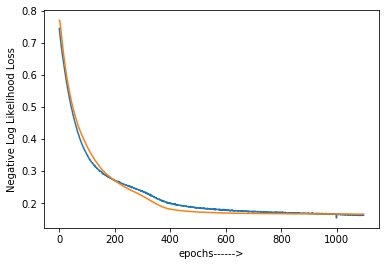

In [448]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)),train_loss)
plt.plot(range(len(test_loss)),test_loss)
plt.xlabel("epochs------>")
plt.ylabel("Negative Log Likelihood Loss")
plt.show()

In [449]:
#predicting on submission and test datasets 
#output of the model will be log of probabilities as we have used LogSoftmax function
model.eval()
y_sub_pred=model(input_xsub.float())
y_test_pred=model(input_xtest.float())
y_train_pred=model(input_xtrain.float())
#covering the log probabilities back to probabalities
y_train_pred_np=np.exp(y_train_pred.detach().numpy())
y_test_pred_np=np.exp(y_test_pred.detach().numpy())
y_sub_pred_np=np.exp(y_sub_pred.detach().numpy())

In [450]:
f1_score_test_list=[]
f1_score_train_list=[]
prob_cuts=np.arange(0.05,1,0.05)
for prob_cut in prob_cuts:
    y_train_pred=np.where(y_train_pred_np[:,1]>prob_cut,1,0)
    y_test_pred=np.where(y_test_pred_np[:,1]>prob_cut,1,0)
    f1_score_train=f1_score(y_train,y_train_pred)
    f1_score_test=f1_score(y_test,y_test_pred)
    f1_score_train_list.append(f1_score_train)
    f1_score_test_list.append(f1_score_test)

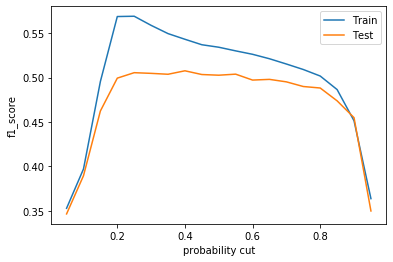

In [441]:
import matplotlib.pyplot as plt
plt.plot(prob_cuts,f1_score_train_list,label='Train')
plt.plot(prob_cuts,f1_score_test_list,label='Test')
plt.legend(loc='upper right')
plt.xlabel("probability cut")
plt.ylabel("f1_score")
plt.show()

In [454]:
max(f1_score_test_list),
cut=prob_cuts[np.argmax(f1_score_test_list)] 

In [458]:
submission1=pd.DataFrame(y_sub_pred_np)
submission1.columns=['nonevent','event']
submission1['ind']=np.where(submission1.event>cut,1,0)
submission1.to_csv('submission7_f2.csv')

In [459]:
torch.save(model, "C:/Users/91821/Desktop/AV/HR/root/model1")
model2=torch.load("C:/Users/91821/Desktop/AV/HR/root/model1")

In [453]:
from sklearn.metrics import f1_score
y_pred=np.where(y_test_pred_np[:,1]>0.39,1,0)
f1_score(y_test, y_pred)

0.5095638867635807

## submission1.to_csv('sub1.csv')

In [255]:
model

Sequential(
  (0): Linear(in_features=54, out_features=100, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=100, out_features=80, bias=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=80, out_features=50, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=50, out_features=2, bias=True)
  (9): LogSoftmax()
)

In [400]:
model

Sequential(
  (0): Linear(in_features=54, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=100, out_features=80, bias=True)
  (5): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=80, out_features=50, bias=True)
  (9): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Dropout(p=0.3, inplace=False)
  (12): Linear(in_features=50, out_features=50, bias=True)
  (13): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU(inplace=True)
  (15): Linear(in_features=50, out_features=2, bias=True)
  (16): LogSoftmax()
)